In [34]:

import query_name_learner
import importlib
import confusion_matrix
import seaborn
import matplotlib.pyplot as plt
import roc_utils
import numpy

importlib.reload(roc_utils)


<module 'roc_utils' from 'c:\\Users\\root\\hyperspace\\dev\\university\\malware_detection\\dns-co\\src\\roc_utils.py'>

In [25]:
JOBFILE = '1vAll-MultinomialNB-mean_f1_0.94-1800-5-TRAIN_TEST_SHUFFLE-2019-06-13_14-28-28.job.gz'

In [27]:
per_user_states = query_name_learner._load_stuff(JOBFILE)

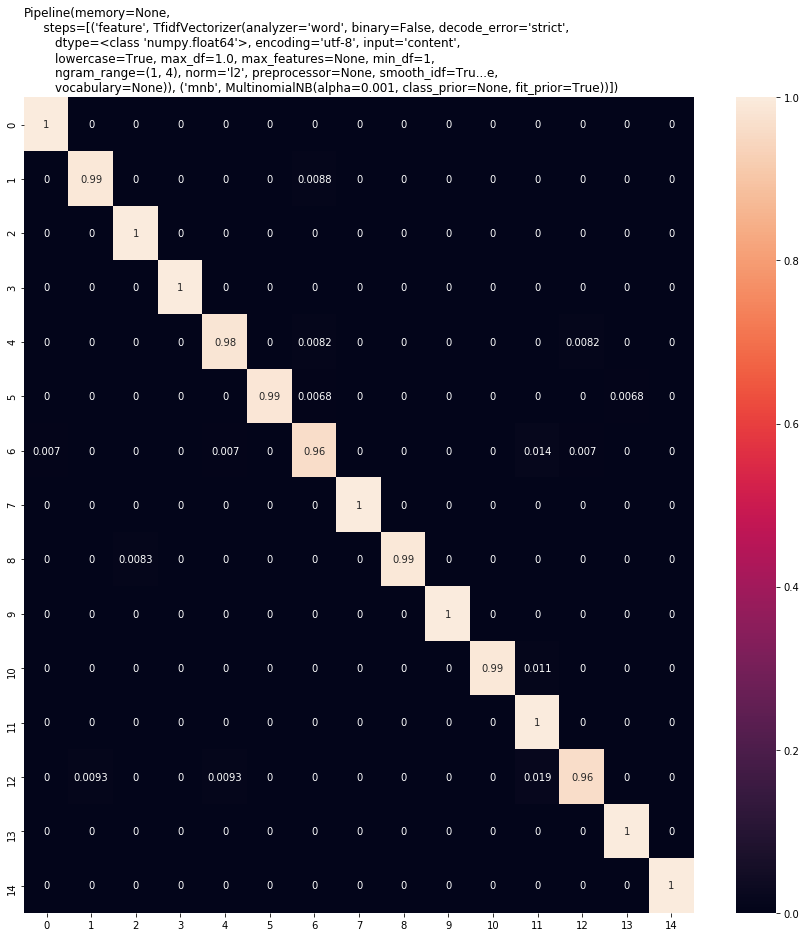

In [24]:
from sklearn import metrics

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
numpy.set_printoptions(precision=2)
cm=confusion_matrix.get_confusion_matrix(state.y_test, state.y_test_pred, normalize=True)
plt.title(state.estimator.best_estimator_, loc='left')
seaborn.heatmap(cm, annot=True)

ROC Curve for user292
1.0


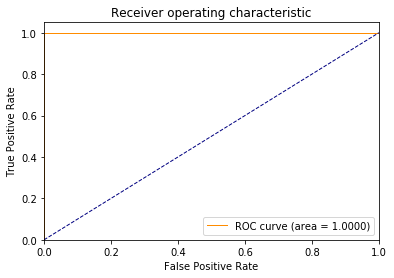

ROC Curve for user301
0.9996342051444058


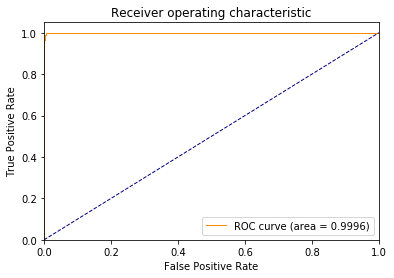

ROC Curve for user303
0.9993973601434576


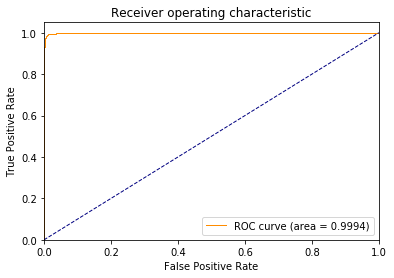

ROC Curve for user305
0.9998993540543206


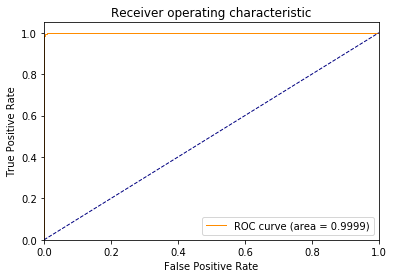

ROC Curve for user306
0.9970442410373761


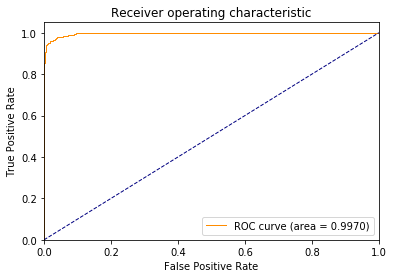

ROC Curve for user308
0.9998985331701409


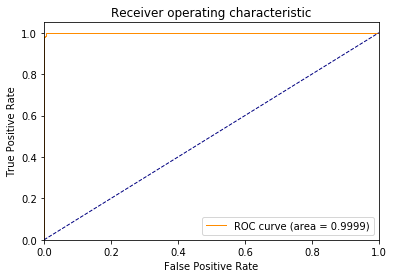

ROC Curve for user316
0.9981185241064099


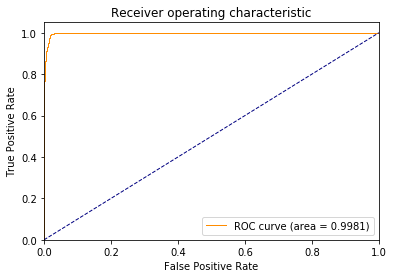

ROC Curve for user334
0.9997995717164045


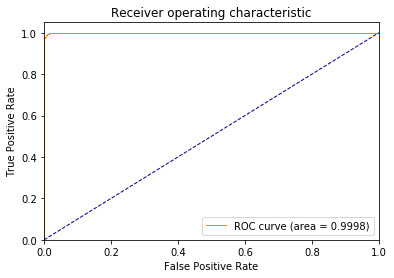

ROC Curve for user341
0.9998519627778144


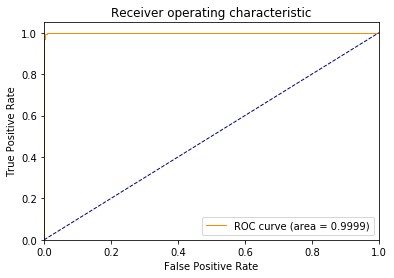

ROC Curve for user343
0.9988286058760073


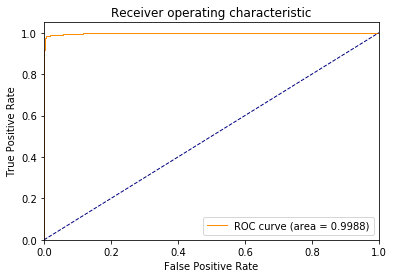

ROC Curve for user348
0.9998860258151528


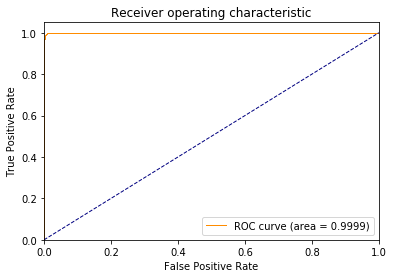

ROC Curve for user354
0.997060334149068


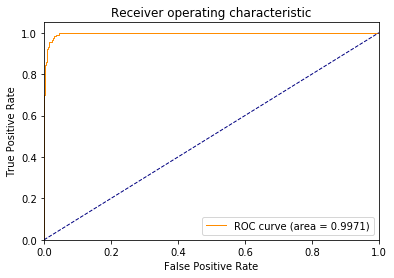

ROC Curve for user372
0.9982078553817213


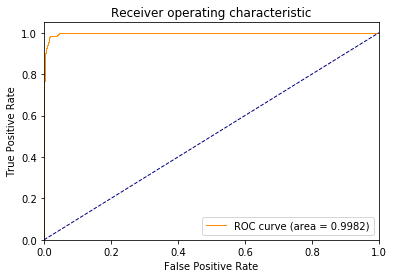

ROC Curve for user387
0.9993658347888266


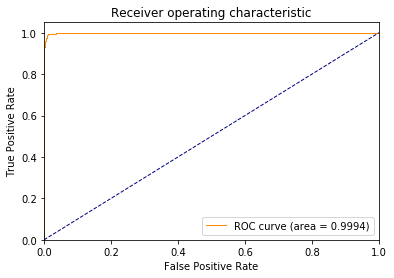

ROC Curve for user392
0.9999363546534457


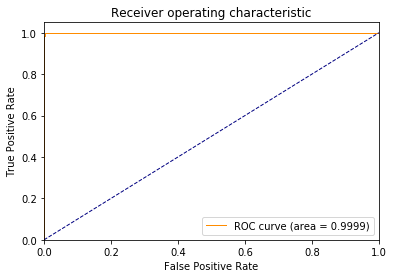

In [35]:
for user, s in per_user_states.items():
    y_proba = s.estimator.predict_proba(s.X_test)
    y_positive_proba = y_proba[:,1]
    roc_curve = metrics.roc_curve(s.y_test, y_positive_proba)
    print(f'ROC Curve for {user}')
    roc_utils.plot_roc_curve(roc_curve)